#### Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [4]:
nTot = 1000
circles_data, circles_labels = make_circles(n_samples = nTot)

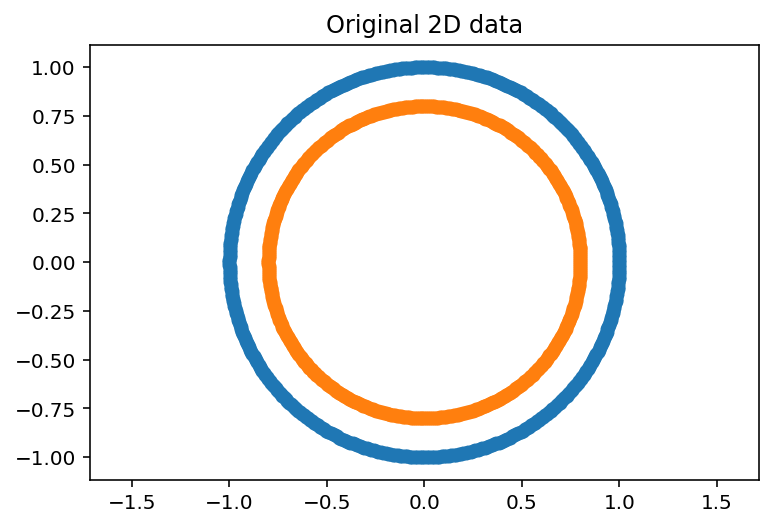

In [79]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split datat into train and test

In [7]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [8]:
nRounds = 3

In [9]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [22]:
dimProj = 10
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Make sequences

In [23]:
# def makeSequences(dataset,Trounds=1):
#     if Trounds==1:
#         return np.expand_dims(dataset,1)
#     elif Trounds>1:
#         numSamps, numFeats = dataset.shape
#         dataset_sequential = np.zeros((numSamps,Trounds,numFeats))
#         for kk in range(Trounds):
#             dataset_sequential[:,kk,:] = dataset
#         return dataset_sequential

In [24]:
# repsTrain = makeSequences(repsTrain_solo,nRounds)
# repsTest = makeSequences(repsTest_solo,nRounds)

#### Convert data to tensors

In [25]:
dataTrain = Variable(torch.from_numpy(repsTrain_proj)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest_proj)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [65]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 128 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [27]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
else:
    print('GPU found, training on GPU')

GPU found, training on GPU


#### MLP AE

In [44]:
n_latent = 2

In [45]:
class MLPAE(nn.Module):
    def __init__(self):
        super(MLPAE, self).__init__()
        
        ##Encoder
        self.layer1 = nn.Linear(10, 5)
        self.layer2 = nn.Linear(5,2)
        self.layer3 = nn.Linear(2, 5)
        self.layer4 = nn.Linear(5,10)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        ## layer 1
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x_latent = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = self.dropout(x)
        x_recon = self.layer4(x)
        
        return x_recon, x_latent

#create the NN
model = MLPAE()
print(model)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

MLPAE(
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=5, bias=True)
  (layer4): Linear(in_features=5, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#### Count number of parameters

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

142

#### Trial pass

In [47]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        recon, latent = model(data)

#### Train AE with MSE

#### Specify loss function and optimizer

In [49]:
#specify loss function
criterion = nn.MSELoss()

#optimizer
eta = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

#### Addresses to collect activations and models

In [50]:
pp = 'C:/Users/abalwani6/Desktop/Spring 2021/Classes/CS 8803 CAB/Final-Project/'
npp = 'saved-models-MLPAE/'
pp_npy = pp+npp+'npys/'
pp_pts = pp+npp+'pts/'

#### Train the network

In [51]:
#number of epochs
n_epochs = 50
div = n_epochs//25 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train model
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad() #clears older gradients
        output, _hidden = model(data) #forward pass
        loss = criterion(output,data) #calculate the loss for the batch
        loss.backward() #backprop
        optimizer.step() #update parameters in direction of the -ve gradient
        train_loss += loss.item()*data.size(0) #update training loss
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),pp_pts+'MLPAE.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), pp_pts+'MLPAE_epoch_'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        model.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            
            ## outputs
            output_test, act_hidden = model(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if i < len(data_test):
                    label = target_test.data[i]

                    activations_hidden_np[cnt] = act_hidden[i]

                    activations_out_np[cnt] = output_test[i,-1]

                    cnt += 1

        np.save(pp_npy+'MLPAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save(pp_npy+'MLPAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

  4%|▍         | 2/50 [00:00<00:03, 12.01it/s]

Epoch: 1, Train Loss Decreased!! (inf-->0.459578)
Epoch: 2, Train Loss Decreased!! (0.459578-->0.454981)
Test Loss: 0.450728

Epoch: 3, Train Loss Decreased!! (0.454981-->0.448186)
Epoch: 4, Train Loss Decreased!! (0.448186-->0.441871)

 12%|█▏        | 6/50 [00:00<00:03, 13.78it/s]


Test Loss: 0.440863

Epoch: 5, Train Loss Decreased!! (0.441871-->0.438222)
Epoch: 6, Train Loss Decreased!! (0.438222-->0.435427)
Test Loss: 0.432155

Epoch: 7, Train Loss Decreased!! (0.435427-->0.429318)

 16%|█▌        | 8/50 [00:00<00:02, 14.30it/s]


Epoch: 8, Train Loss Decreased!! (0.429318-->0.427263)
Test Loss: 0.423997

Epoch: 9, Train Loss Decreased!! (0.427263-->0.422423)
Epoch: 10, Train Loss Decreased!! (0.422423-->0.417919)

 24%|██▍       | 12/50 [00:00<00:02, 15.19it/s]


Test Loss: 0.416067

Epoch: 11, Train Loss Decreased!! (0.417919-->0.415514)
Epoch: 12, Train Loss Decreased!! (0.415514-->0.411406)
Test Loss: 0.408406

Epoch: 13, Train Loss Decreased!! (0.411406-->0.407979)

 28%|██▊       | 14/50 [00:00<00:02, 15.35it/s]


Epoch: 14, Train Loss Decreased!! (0.407979-->0.405921)
Test Loss: 0.400698

Epoch: 15, Train Loss Decreased!! (0.405921-->0.403774)
Epoch: 16, Train Loss Decreased!! (0.403774-->0.396779)

 36%|███▌      | 18/50 [00:01<00:02, 15.34it/s]


Test Loss: 0.393000

Epoch: 17, Train Loss Decreased!! (0.396779-->0.394313)
Epoch: 18, Train Loss Decreased!! (0.394313-->0.391673)
Test Loss: 0.384715

Epoch: 19, Train Loss Decreased!! (0.391673-->0.384152)

 40%|████      | 20/50 [00:01<00:01, 15.12it/s]


Epoch: 20, Train Loss Decreased!! (0.384152-->0.383785)
Test Loss: 0.375978

Epoch: 21, Train Loss Decreased!! (0.383785-->0.377930)
Epoch: 22, Train Loss Decreased!! (0.377930-->0.372007)


 48%|████▊     | 24/50 [00:01<00:01, 15.51it/s]

Test Loss: 0.367169

Epoch: 23, Train Loss Decreased!! (0.372007-->0.369695)
Epoch: 24, Train Loss Decreased!! (0.369695-->0.366032)
Test Loss: 0.357715

Epoch: 25, Train Loss Decreased!! (0.366032-->0.365615)

 52%|█████▏    | 26/50 [00:01<00:01, 15.66it/s]


Epoch: 26, Train Loss Decreased!! (0.365615-->0.357143)
Test Loss: 0.348157

Epoch: 27, Train Loss Decreased!! (0.357143-->0.353241)
Epoch: 28, Train Loss Decreased!! (0.353241-->0.351814)

 60%|██████    | 30/50 [00:01<00:01, 14.98it/s]


Test Loss: 0.337908

Epoch: 29, Train Loss Decreased!! (0.351814-->0.343596)
Epoch: 30, Train Loss Decreased!! (0.343596-->0.342739)
Test Loss: 0.327222



 64%|██████▍   | 32/50 [00:02<00:01, 14.98it/s]

Epoch: 31, Train Loss Decreased!! (0.342739-->0.334289)
Epoch: 32, Train Loss Decreased!! (0.334289-->0.333352)
Test Loss: 0.315770

Epoch: 33, Train Loss Decreased!! (0.333352-->0.326844)
Epoch: 34, Train Loss Decreased!! (0.326844-->0.321682)

 72%|███████▏  | 36/50 [00:02<00:00, 14.56it/s]


Test Loss: 0.303775

Epoch: 35, Train Loss Decreased!! (0.321682-->0.320220)
Epoch: 36, Train Loss Decreased!! (0.320220-->0.311870)
Test Loss: 0.291394



 76%|███████▌  | 38/50 [00:02<00:00, 14.74it/s]

Epoch: 37, Train Loss Decreased!! (0.311870-->0.306843)
Test Loss: 0.279132

Epoch: 39, Train Loss Decreased!! (0.306843-->0.297099)
Epoch: 40, Train Loss Decreased!! (0.297099-->0.291606)
Test Loss: 0.266359


 84%|████████▍ | 42/50 [00:02<00:00, 15.12it/s]


Epoch: 41, Train Loss Decreased!! (0.291606-->0.281534)
Test Loss: 0.253127

Epoch: 43, Train Loss Decreased!! (0.281534-->0.279264)


 92%|█████████▏| 46/50 [00:03<00:00, 14.64it/s]

Epoch: 44, Train Loss Decreased!! (0.279264-->0.274509)
Test Loss: 0.240366

Epoch: 45, Train Loss Decreased!! (0.274509-->0.260663)
Test Loss: 0.227673



 96%|█████████▌| 48/50 [00:03<00:00, 14.87it/s]

Epoch: 47, Train Loss Decreased!! (0.260663-->0.259665)
Test Loss: 0.215095

Epoch: 49, Train Loss Decreased!! (0.259665-->0.252191)
Epoch: 50, Train Loss Decreased!! (0.252191-->0.242449)

100%|██████████| 50/50 [00:03<00:00, 15.04it/s]


Test Loss: 0.202825



Text(0, 0.5, 'MSE')

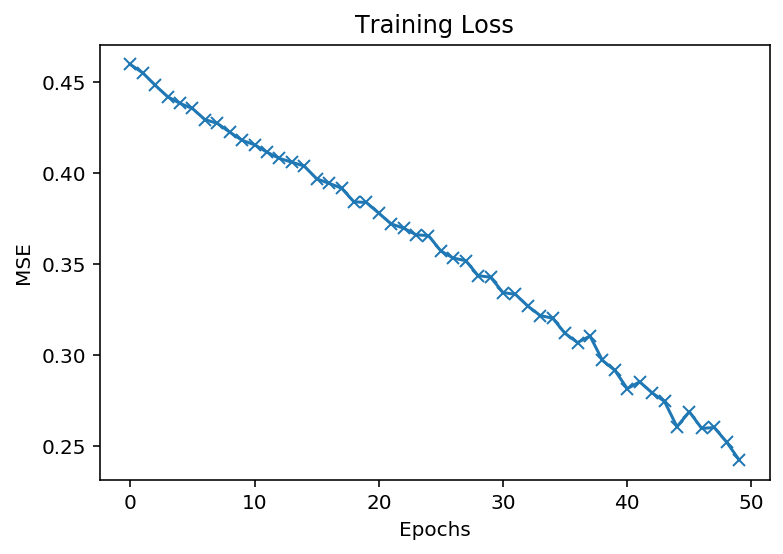

In [52]:
plt.plot((train_losses),'-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### Load best model

In [53]:
## best epoch = 50
print(best_epoch)

50


In [55]:
model.load_state_dict(torch.load(pp_pts+'MLPAE.pt'))

<All keys matched successfully>

In [68]:
model.eval()

test_loss = 0.0
        
activations_latent_np = np.zeros((nTest,n_latent))
activations_out_np = np.zeros((nTest,dimProj))

cnt = 0

for data_test, target_test in test_loader:
    if train_on_gpu:
        data_test, target_test = data_test.float().cuda(), target_test.float().cuda()

    ## outputs
    output_test, act_hidden = model(data_test)

    # calculate the batch loss
    loss = criterion(output_test, data_test)

    # update test loss 
    test_loss += loss.item()*data_test.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_test = np.squeeze(output_test.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_test):
            label = target_test.data[i]

            activations_hidden_np[cnt] = act_hidden[i]

            activations_out_np[cnt] = output_test[i,-1]

            cnt += 1

np.save(pp_npy+'MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
np.save(pp_npy+'MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.202825



In [70]:
model.eval()

train_loss = 0.0
        
activations_latent_train_np = np.zeros((nTrain,n_latent))
activations_out_train_np = np.zeros((nTrain,dimProj))

cnt = 0

for data_train, target_train in train_loader_noShuffle:
    if train_on_gpu:
        data_train, target_train = data_train.float().cuda(), target_train.float().cuda()

    ## outputs
    output_train, act_hidden = model(data_train)

    # calculate the batch loss
    loss = criterion(output_train, data_train)

    # update train loss 
    train_loss += loss.item()*data_train.size(0)

    act_hidden = np.squeeze(act_hidden.detach().cpu().numpy())
    output_train = np.squeeze(output_train.detach().cpu().numpy())

    for i in range(bs):
        if i < len(data_train):
            label = target_train.data[i]

            activations_latent_train_np[cnt] = act_hidden[i]

            activations_out_train_np[cnt] = output_train[i,-1]

            cnt += 1

# np.save(pp_npy+'MLPAE_latent_epoch_'+str(best_epoch), activations_hidden_np)
# np.save(pp_npy+'MLPAE_out_epoch_'+str(best_epoch), activations_out_np)

# average train loss
train_loss = train_loss/len(train_loader.dataset)
print('Test Loss: {:.6f}\n'.format(train_loss))

Test Loss: 0.198545



#### Plot latent data

Text(0.5, 1.0, 'Latent Space - Test Data')

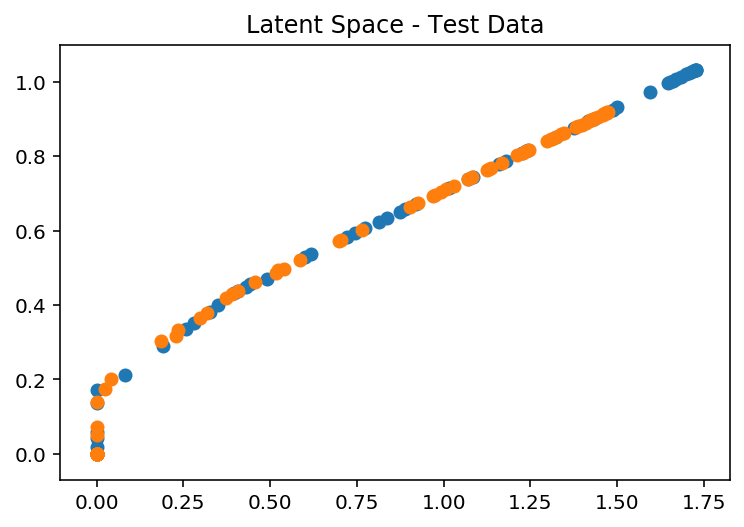

In [78]:
for ii in range(2):
    col = 'C' + str(ii)
    idx = np.where(labelsTest==ii)[0]
    plt.scatter(activations_hidden_np[idx,0],activations_hidden_np[idx,1],c=col)
plt.title('Latent Space - Test Data')

In [74]:
# for ii in range(2):
#     col = 'C' + str(ii)
#     idx = np.where(labelsTrain==ii)[0]
#     plt.scatter(activations_latent_train_np[idx,0],activations_latent_train_np[idx,1],c=col)
# plt.title('Train data')

#### Train a linear classifier on top of latent representations

In [75]:
from sklearn.linear_model import Perceptron

In [76]:
clf = Perceptron(tol=1e-3, random_state=22)
clf.fit(activations_latent_train_np, labelsTrain)
print('Train Accuracy = ',clf.score(activations_latent_train_np, labelsTrain))
print('Test Accuracy = ',clf.score(activations_hidden_np, labelsTest))

Train Accuracy =  0.59
Test Accuracy =  0.605


In [93]:
nRuns = 5
numTrainSamps = [10,25,50,100,200,300,400,500,600,700,800]
acc_list_train = np.zeros((nRuns,len(numTrainSamps)))
acc_list_test = np.zeros((nRuns,len(numTrainSamps)))

for ii in range(nRuns):
    for cnt, kk in enumerate(numTrainSamps):
            idxs = np.sort(np.random.choice(nTrain,kk,replace=False))
            clf_temp = Perceptron(tol=1e-3, random_state=22)
            clf_temp.fit(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_train[ii,cnt] = clf_temp.score(activations_latent_train_np[idxs], labelsTrain[idxs])
            acc_list_test[ii,cnt] = clf_temp.score(activations_hidden_np, labelsTest)

In [108]:
# ci1 = 1.96 * np.std(acc_list_train)/np.mean(acc_list_train)
# ci2 = 1.96 * np.std(acc_list_test)/np.mean(acc_list_test)

# fig, ax = plt.subplots()
# ax.plot(numTrainSamps,np.mean(acc_list_train,axis=0))
# ax.fill_between(numTrainSamps,
#                 (np.mean(acc_list_train,axis=0)-ci1), (np.mean(acc_list_train,axis=0)+ci1), color='b', alpha=.1)

# ax.plot(numTrainSamps,np.mean(acc_list_test,axis=0))
# ax.fill_between(numTrainSamps,
#                 (np.mean(acc_list_test,axis=0)-ci2), (np.mean(acc_list_test,axis=0)+ci2), color='r', alpha=.1)

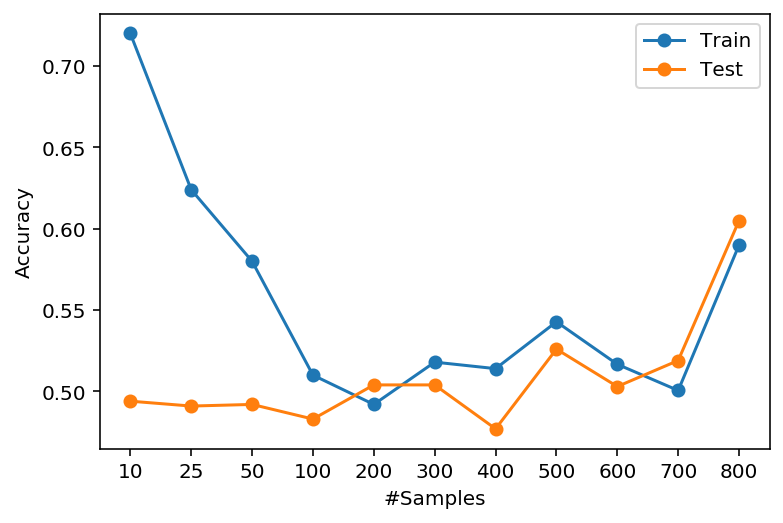

In [110]:
plt.plot(np.mean(acc_list_train,axis=0),'-o',label='Train')
plt.plot(np.mean(acc_list_test,axis=0),'-o',label='Test')
plt.legend()
plt.xticks(np.arange(len(numTrainSamps)),np.array(numTrainSamps))
plt.ylabel('Accuracy')
plt.xlabel('#Samples')
plt.show()